### Скрытые марковские модели

Реализация методов является полезной, но технически сложной, поэтому мы воспользуемся готовой реализацией `hmmlearn`. Документация http://hmmlearn.readthedocs.io/. Интерфейс данной библиотеки максимально близок к библиотеке `scikit-learn`. 

Все необходимые комментарии по интерфейсу библиотеки `hmmlearn` приведены в коде далее.

In [1]:
import numpy as np
import sys
from hmmlearn import hmm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import hmmlearn
print(hmmlearn.__version__)

0.2.1


In [3]:
# Если при использовании библиотеки будут появлятся различные warnings,
# раскомментируйте и выполните следующий код
import warnings
warnings.filterwarnings("ignore")

Зададим некоторую скрытую марковскую модель

In [4]:
# Объявление скрытой марковской модели с двумя скрытыми состояниями, 
# в которой предполагается, что каждое состояние (Х) может генерировать 
# гауссовский случайный вектор с произвольной матрицей ковариаций (Y).
# Используется метод Витерби.
# Поставьте 'map', чтобы использовать метод forward-backward.
model = hmm.GaussianHMM(n_components=2, covariance_type='full', 
                        algorithm='viterbi')

# Параметры марковской цепи - начальное состояние и матрица переходных вероятностей
model.startprob_ = np.array([0.6, 0.4])
model.transmat_ = np.array([[0.9, 0.1],
                            [0.07, 0.93]])

# Параметры условных распределений Y_j при условии X_j - вектора средних и
# матрица ковариаций по количеству состояний. Поскольку в данном случае
# распределения одномерные, ниже записаны два вектора размерности 1
# и две матрицы размерности 1x1
model.means_ = np.array([[0.0], [3.0]])
model.covars_ = np.array([[[1]], [[1]]])

Сгенерируем некоторую последовательность с помощью определенной выше модели.

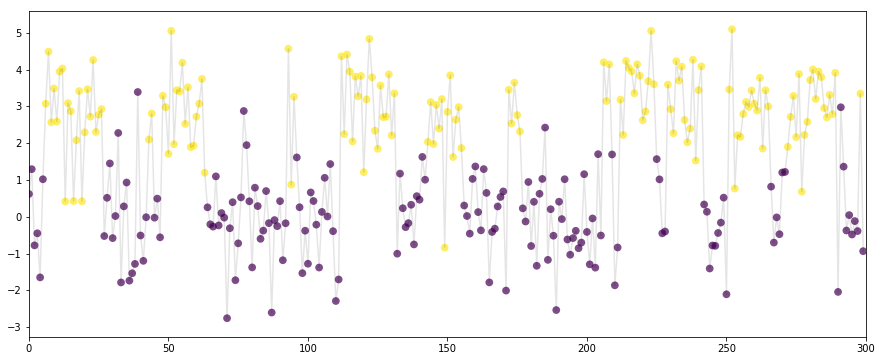

In [5]:
size = 300
Y, X = model.sample(size)  # Y наблюдаемы, X скрытые

plt.figure(figsize=(15, 6))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=np.array(X), lw=0, s=60, alpha=0.7)
plt.xlim((0, size))
plt.show()

На основе сгенерированной выше последовательности оценим параметры ("обучим") скрытой марковской модели и значения скрытых состояний.

In [6]:
# Объявление скрытой марковской модели, в которой при оценке параметров 
# будет производиться не более n_iter итераций EM-алгоритма.
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full",
                          n_iter=100, algorithm='viterbi')

# Оценка параметров ("обучение")
remodel.fit(Y)  

# Оценка ("предсказание") значений скрытых состояний
X_predicted = remodel.predict(Y)

Теперь изобразим полученные результаты. На обоих графиках непрозразными маленькими кружочками отмечена исходная последовательность. Полупрозрачными большими кружочками отмечены оценки значений скрытых состояний. На первом графике отмечены все такие точки, на втором только те из них, оценка значения скрытого состояния получилась непрпавильно.

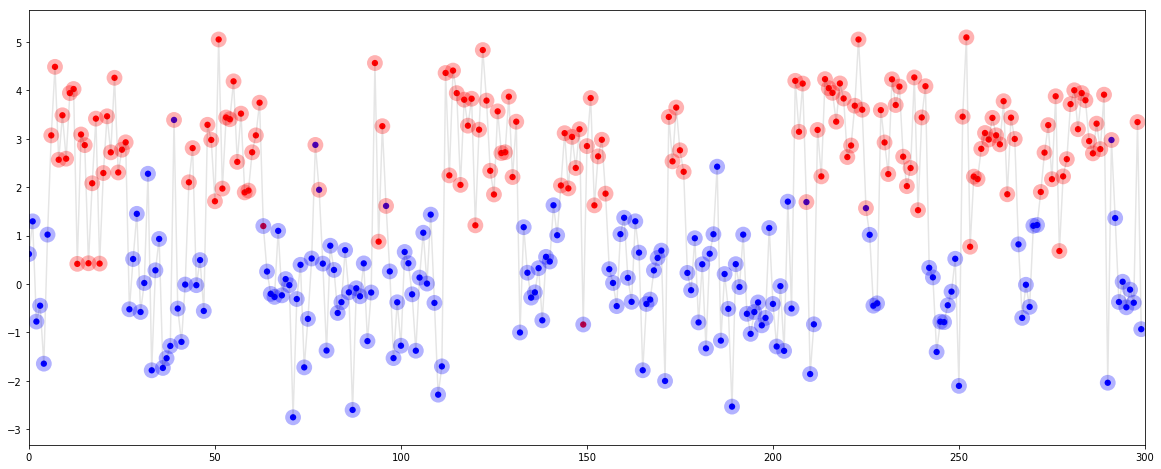

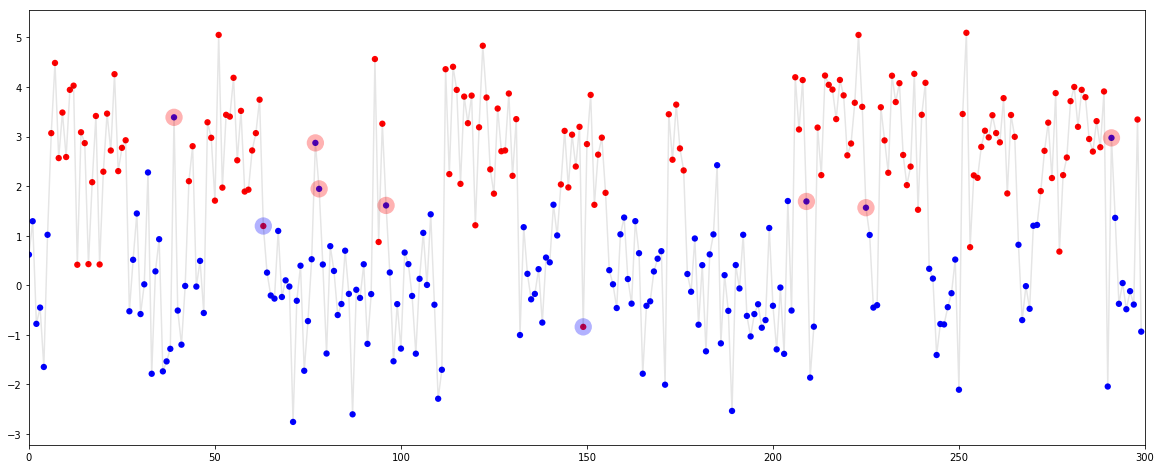

In [7]:
colors = np.array(['blue', 'red'])

# Состояния определяются с точностью до их перестановки.
# При необходимости меняем местами состояния
if (X != X_predicted).sum() > size / 2:
    X_predicted = 1 - X_predicted

plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X_predicted)], 
            lw=0, s=250, alpha=0.3)
plt.xlim((0, size))
plt.show()

plt.figure(figsize=(20, 8))
plt.plot(np.arange(size), Y[:, 0], color='black', alpha=0.1)
plt.scatter(np.arange(size), Y[:, 0], c=colors[np.array(X)], 
            lw=0, s=40, alpha=1)
plt.scatter(np.arange(size)[X != X_predicted], Y[:, 0][X != X_predicted], 
            c=colors[np.array(X_predicted)[X != X_predicted]], 
            lw=0, s=300, alpha=0.3)
plt.xlim((0, size))
plt.show()

Как понять, что EM-алгоритм сошелся? Для этого нужно посчитать значение некоторого функционала (см. презентацию), который умеет считать библиотека `hmmlearn`, поэтому мы всего лишь посмотрим на его значения. Данная функциональность в библиотеке реализованна слишком странно. Следуйте комментариям.

In [8]:
saved_strerr = sys.stderr  # сохраним в переменную поток вывода ошибок
sys.stderr = open('est_values.txt', 'w')  # и перенаправим его в файл

# ============
# Для вывода значений функционала нужно поставить параметр verbose
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full",
                          n_iter=100, verbose=True)
remodel.fit(Y)  
X_predicted = remodel.predict(Y)
# ============

# Возвращаем все, как было
sys.stderr = saved_strerr

Теперь можно загрузить значения и построить график

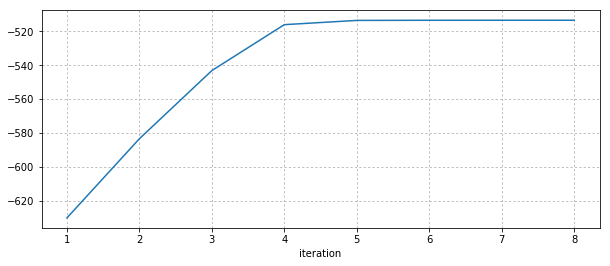

In [9]:
values = np.loadtxt('./est_values.txt')

plt.figure(figsize=(10, 4))
plt.plot(values[:, 0], values[:, 1])
plt.xlabel('iteration')
plt.grid(ls=':')
plt.show()